## COMP9517 Group Project 
## Task3 Code Implementation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
from scipy.ndimage import label, generate_binary_structure
import glob

### Pre-Processing

In [2]:
def preprocessing(img):
    
    rows, cols = img.shape[0], img.shape[1]
    for i in range(0, 300):
        for j in range(0, cols):
            img[i,j] = 0

    return img


In [3]:
def gaussian(image):

    return cv2.GaussianBlur(image, (5,5), 0)

In [4]:
def RGB_space(image):
    
    lower_threshold = np.uint8([160, 160, 160])
    upper_threshold = np.uint8([255, 255, 255])
    white = cv2.inRange(image, lower_threshold, upper_threshold)

    return cv2.bitwise_and(image, image, mask = white)


In [5]:

def HSV_space(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # extract Yellow color 
    lower_threshold = np.uint8([10, 10, 170])
    upper_threshold = np.uint8([180, 30, 255])
    yellow = cv2.inRange(hsv, lower_threshold, upper_threshold)
    
    return cv2.bitwise_and(image, image, mask = yellow)


In [6]:
def combine_rgb_hsv(rgb,hsv):
    return cv2.bitwise_or(rgb,hsv)


### Detection

In [7]:
def canny_detector(image, low_threshold = 50, high_threshold = 80, soble = 3):

    return cv2.Canny(image, low_threshold, high_threshold, soble)


In [8]:
def hough_transform(image):
 
    return cv2.HoughLinesP(image, rho = 1, theta = np.pi/180, threshold = 20,
                           minLineLength = 20, maxLineGap = 90)


In [9]:
def draw_lines(image, lines, color, thickness):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


### Optimization

In [10]:
def pixel_points(y1, y2, line):

    x1 = int((y1 - line[1])/line[0])
    x2 = int((y2 - line[1])/line[0])
    return [[x1, int(y1), x2, int(y2)]]

In [11]:

def slope (image, lines):
    line1 = []
    line2 = []
    line3 = []
    
    line1_length = []
    line2_length = []
    line3_length = []

    line4 = []
    line4_length = []

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - (slope * x1)
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
#         print(slope, intercept)
        if slope > 0 and slope < 0.5:
            line1.append((slope, intercept))
            line1_length.append((length))

        if slope > 0 and slope > 0.5:
            line2.append((slope, intercept))
            line2_length.append((length))

        if slope < 0 and slope < -0.5:
            line3.append((slope, intercept))
            line3_length.append((length))
        

        if slope < -0.3 and slope > -0.5:
            line4.append((slope, intercept))
            line4_length.append((length))
                

    line1_lane  = np.dot(line1_length,  line1) / np.sum(line1_length) 
    line2_lane  = np.dot(line2_length,  line2) / np.sum(line2_length)
    line3_lane  = np.dot(line3_length,  line3) / np.sum(line3_length)
    line4_lane  = np.dot(line4_length,  line4) / np.sum(line4_length)

    
    y1 = image.shape[0]
    y2 = 300
    
    line1_final = pixel_points(y1, y2, line1_lane)
    line2_final = pixel_points(y1, y2, line2_lane)
    line3_final = pixel_points(y1, y2, line3_lane)
    line4_final = pixel_points(y1, y2, line4_lane)
    
    all_final = []
    if(line1_final):
        all_final.append(line1_final)
    if(line2_final):
        all_final.append(line2_final)
    if(line3_final):
        all_final.append(line3_final)
    if(line4_final):
        all_final.append(line4_final)

    return all_final
    

## main - Results

In [12]:

count = 0
img_array = []

for filename in glob.glob('./train_set/clips/0313-1/2460/*.jpg'):

    input_img = cv2.imread(filename)
    original = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    img = np.copy(original)
    
    # pre-processing
    pre_img = preprocessing(img)
    gauss_img = gaussian(pre_img)

    # color selection
    rgb_img = RGB_space(gauss_img)
    hsv_img = HSV_space(gauss_img)
    color_img = combine_rgb_hsv(rgb_img,hsv_img)

    # Canny Edge detection and Hough Transform
    canny_img = canny_detector(color_img)
    lines = hough_transform(canny_img)
    result = np.copy(color_img)
    result = draw_lines(result, lines, [255, 0, 0],2)

    # draw_lines
    lines_final = slope(original, lines)
    output = draw_lines(original, lines_final, [0, 255, 0], 15)

    height, width, layers = img.shape
    size = (width,height)
    img_array.append(output)
    count += 1

 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

(1280, 720)


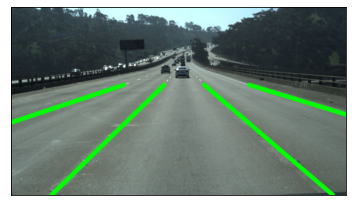

In [13]:
plt.imshow(img_array[19])
plt.xticks([])
plt.yticks([])
plt.show()